# PS4E8 : **Binary Prediction of Poisonous Mushrooms**

## >> **USE AUTO-ML (AUTOGLUON)**

## 00. **SET WORK ENVORINMENT**

#### 00.1. **DEFINE PRE-VARIABELS**

In [20]:
seed_num = 2024
compet_nm = 'PS4E8'
run_time_limit = 60*60*24*2 # 2 days

#### 00.2. **IMPORT PACKAGES AND SET OPTIONS**

In [21]:
#(1) Import packages
import os
import warnings
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor
import shap

#(2) Set system options
warnings.filterwarnings(action='ignore')
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
shap.initjs()

#### 00.3. **CREATE FUNCTIONS**

In [22]:
#(1) Create `relocate_col()` function
def relocate_col(df:pd.DataFrame, tar_col:str, std_col:str, how:str='after') -> pd.DataFrame : 
    '''
    Reorder columns in a DataFrame by moving a target column relative to a standard column.

    Parameters :
    - df (pd.DataFrame): The DataFrame from which the column will be relocated.
    - tar_col (str): The name of the column to be relocated.
    - std_col (str): The column relative to which `tar_col` will be relocated.
    - how (str, optional): Specifies the placement of `tar_col` relative to `std_col`.
      It can be 'after' (default) or 'before'.

    Returns :
    - pd.DataFrame: A new DataFrame with the column `tar_col` relocated as specified.
    '''
    col_ary = np.array(object=df.columns)
    tar_col_idx = np.where(col_ary==tar_col)[0][0]
    std_col_idx = np.where(col_ary==std_col)[0][0]
    col_ary = np.delete(arr=col_ary, obj=tar_col_idx)
    if how == 'after' : 
        if std_col_idx == len(col_ary) : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col)
        else :
            col_ary = np.insert(arr=col_ary, obj=std_col_idx+1, values=tar_col)
    elif how == 'before' : 
        if std_col_idx == 0 : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col) 
        else : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx-1, values=tar_col)
    else : 
        pass
    df = df.loc[:, col_ary]
    return df 

#(2) Create `diagnose_df()` function
def diagnose_df(df:pd.DataFrame) -> pd.DataFrame : 
    '''
    Generates a diagnostic summary for a pandas DataFrame, reporting details like data types, 
    count of missing values, and uniqueness for each column.

    Parameters :
    - df (pd.DataFrame): The DataFrame to be diagnosed.

    Returns :
    - pd.DataFrame: A summary table with diagnostics for each column in the input DataFrame, 
      including the column name, data type, total rows, count and rate of missing values, 
      and count and rate of unique values.
    '''
    output = pd.DataFrame(data=df.dtypes).reset_index()
    output.columns = ['COLUMN_NM', 'DATA_TYPE']
    output.loc[:, 'ROW_CNT'] = len(df)
    output.loc[:, 'NA_CNT'] = df.isna().sum().values
    output.loc[:, 'NA_RATE'] = output.loc[:, 'NA_CNT'] / output.loc[:, 'ROW_CNT']
    output.loc[:, 'UNIQUE_CNT'] = df.nunique().values
    output.loc[:, 'UNIQUE_RATE'] = output.loc[:, 'UNIQUE_CNT'] / output.loc[:, 'ROW_CNT']
    format_columns = ['ROW_CNT', 'NA_CNT', 'UNIQUE_CNT']
    for col in format_columns:
        output[col] = output[col].apply(func=lambda x: f'{x:,.0f}')
    return output

#(3) Create `diagnose_num_df()` function
def diagnose_num_df(df:pd.DataFrame) -> pd.DataFrame : 
    '''
    Generates a diagnostic summary for numeric columns in a pandas DataFrame, including statistical 
    measures like mean, median, mode, and various percentiles.

    Parameters :
    - df (pd.DataFrame): The DataFrame to be diagnosed. Only numeric columns will be considered.

    Returns :
    - pd.DataFrame: A summary table with diagnostics for each numeric column in the input DataFrame, 
      including count, mean, standard deviation, min, max, median, mode, and various percentiles.
    '''
    df = df.select_dtypes(include='number')
    output = df.describe(include='all', percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()
    output.loc[:, 'median'] = df.median()
    output.loc[:, 'mode'] = df.mode().values[0]
    output = relocate_col(df=output, tar_col='median', std_col='mean', how='after')
    output = relocate_col(df=output, tar_col='mode', std_col='median', how='after')
    output.columns = np.array(object=list(map(np.char.upper, output.columns)))
    output = output.rename(columns={'COUNT' : 'ROW_CNT'})
    output['ROW_CNT'] = output['ROW_CNT'].astype(dtype='int')
    return output

#(4) Create `summary_cat_cols()` function
## NEED REFACTORING ! ##
def summary_cat_cols(df:pd.DataFrame, pick_col:str, markdown_yn:str='y') -> pd.DataFrame :
    counts = df.loc[:, pick_col].astype(dtype='str').value_counts()
    percentages = (counts / len(df) * 100)
    output = pd.DataFrame(data={
        'COL_NM'    : pick_col,
        'VALUE'     : counts.index,
        'CNT'       : counts.values,
        'RATE': percentages.values
    })
    CON = (output.loc[:, 'COL_NM'] == pick_col)
    output = output.loc[CON, :]
    if markdown_yn == 'y' :
        output = output.to_markdown(tablefmt='simple_grid', floatfmt='.2f')
    return output

#(5) Create `draw_hist()` function
def draw_hist(df:pd.DataFrame) -> plt.plot :
    '''
    Draws histograms for numerical features in the given DataFrame.

    Parameters :
    - df (pd.DataFrame): The DataFrame to be diagnosed. Only numeric columns will be considered.

    Returns :
    - plt.plot
    '''
    num_cols = df.select_dtypes(include=['number']).columns
    col_size = 3
    row_size = (len(num_cols) + col_size - 1) // col_size
    fig, axes = plt.subplots(nrows=row_size, ncols=col_size, figsize=(18, 5 * row_size))
    fig.suptitle(t='Distribution of Numerical Features', fontweight='bold', fontsize=16)
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.histplot(data=df.loc[:, col], kde=True, ax=axes[i], color='skyblue', element='step', stat='density')
        axes[i].set_title(label=f'Distribution of `{col}`', fontsize=14)
        axes[i].set_xlabel(xlabel=col, fontsize=12)
        axes[i].set_ylabel(ylabel='Density', fontsize=12)
        axes[i].grid(visible=False)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

#(6) Create `replace_cat_val()` function
def replace_cat_val(value:str) -> str :
    '''
    Cleans the input string by removing specific patterns and numerical values.
    If the cleaned string is a single alphabetical character, returns it; otherwise, returns NaN.
    
    Parameters:
    - value (str): The input string to be processed.
    
    Returns:
    - str or np.nan: The processed string if it is a single alphabetical character, otherwise NaN.
    '''
    clean_val = re.sub(pattern=r'\b(\w) \1\b', repl=r'\1', string=value)
    clean_val = re.sub(pattern=r'(\d+\s|x\s|is\s|does\s|has\s|has-|\s+has-ring|\d+\.\s*)', repl='', string=clean_val)
    if len(clean_val) == 1 and clean_val.isalpha():
        output = clean_val
    else:
        output = np.nan
    return output

#(7) Create `handle_cat_val()` function
def handle_cat_val(df:pd.DataFrame, markdown_yn:str='y') -> pd.DataFrame:
    ''' 
    Processes categorical values in all object-type columns of the DataFrame using `replace_cat_val()` function.
    Tracks and prints changes from the original to the cleaned values in a markdown table.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with categorical columns to be processed.
    
    Returns:
    - pd.DataFrame: The DataFrame with cleaned categorical values.
    '''
    cat_cols = df.select_dtypes(include=['object']).columns

    for col in cat_cols :
        changes = []
        original_values = df.loc[:, col].astype(dtype=str)  # Convert to string to handle any non-string categorical data.
        cleaned_values = original_values.apply(func=replace_cat_val)

        for original, cleaned in zip(original_values, cleaned_values) :
            if original != cleaned:
                cleaned_value = cleaned if pd.notna(obj=cleaned) else "NaN"
                changes.append({'AS_IS_VAL': original.strip(), 'TO_BE_VAL': cleaned_value.strip()})

        if changes :  # Only print if there are changes
            if markdown_yn == 'y' :
                print(f'>> Handle category value : "{col}" columns')
                changes_df = pd.DataFrame(
                    data=changes
                ).drop_duplicates(                
                ).sort_values(
                    by=['TO_BE_VAL', 'AS_IS_VAL'], 
                    ascending=False
                ).reset_index(
                    drop=True
                )
                print(changes_df.to_markdown(tablefmt='simple_grid'))
                print()  # Add a blank line for better readability

        df.loc[:, col] = cleaned_values

    return df

#(8) Create `handle_unseen_cat_val()` function
def handle_unseen_cat_val(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    '''
    Replaces categories in the test dataset that do not appear in the train dataset with NaN.
    
    Parameters:
    - train (pd.DataFrame): The training dataset containing the column to analyze.
    - test (pd.DataFrame): The test dataset containing the column to analyze.
    - column_name (str): The name of the categorical column to process.
    
    Returns:
    - pd.DataFrame: The modified test dataset with unseen categories replaced by NaN.
    '''
    # Get the set of unique categories in the train dataset column
    cat_cols = test.select_dtypes(include=['object']).columns
    for col in cat_cols :
        train_cat_var = set(train.loc[:, col].dropna().unique())
    
        # Replace categories in the test dataset that are not in the train dataset
        test.loc[:, col] = test.loc[:, col].apply(func=lambda x : x if x in train_cat_var else np.nan)
    
    return test

#(9) Create `compare_cat_cols()` function -> Information leakage?
## NEED REFACTORING ! ##
def compare_cat_cols(train:pd.DataFrame, test:pd.DataFrame, pick_col:str, markdown_yn:str) -> pd.DataFrame:
    '''
    Compare categorical values and their frequencies in a specified column between two dataframes (train and test),
    including detailed frequency counts next to each category in markdown format.

    Parameters:
    - train (pd.DataFrame): Training dataset containing the column to analyze.
    - test (pd.DataFrame): Testing dataset containing the column to analyze.
    - column (str): Column name to analyze for categorical differences and frequencies.

    Returns:
    - str: Summary table in markdown format showing unique and common categories between datasets along with their frequencies.
    '''
    # Get unique values and their counts from each dataset's specified column
    train_counts = train.loc[:, pick_col].value_counts(dropna=False)
    test_counts = test.loc[:, pick_col].value_counts(dropna=False)
    
    # Determine unique and common values
    train_values = set(train_counts.index)
    test_values = set(test_counts.index)
    
    only_in_train = train_values - test_values
    only_in_test = test_values - train_values
    common_values = train_values & test_values
    
    # Prepare the results DataFrame
    output = pd.DataFrame(data={
        'CAT_VAL'    : list(only_in_train) + list(only_in_test) + list(common_values),
        'TRAIN_CNT'  : [train_counts.get(key=val, default=np.nan) for val in list(only_in_train) + list(only_in_test) + list(common_values)],
        'TEST_CNT'   : [test_counts.get(key=val, default=np.nan) for val in list(only_in_train) + list(only_in_test) + list(common_values)],
    })

    # Ensure all count columns are float for consistent datatype
    output[['TRAIN_CNT', 'TEST_CNT']] = output[['TRAIN_CNT', 'TEST_CNT']].astype(dtype=pd.Int64Dtype())

    #
    output.loc[:, 'TRAIN_RATE'] = output.loc[:, 'TRAIN_CNT'] / train.shape[0] * 100
    output.loc[:, 'TEST_RATE'] = output.loc[:, 'TEST_CNT'] / test.shape[0] * 100

    # Sorting the output
    output = output.sort_values(by=['TRAIN_CNT', 'TEST_CNT'], ascending=False)
    
    #
    output = relocate_col(df=output, tar_col='TRAIN_RATE', std_col='TRAIN_CNT', how='after')

    # Add markdown formatting for better presentation in tables
    if markdown_yn == 'y' :
        output = output.to_markdown(tablefmt='simple_grid', floatfmt='.4f')
    return output


#### 00.4. **CREATE CLASSES**

In [23]:
#(1) Create `AutogluonWrapper`
class AutogluonWrapper :
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        if target_class is None and predictor.problem_type != 'regression' :
            print("Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        if self.ag_model.problem_type == "regression" or self.target_class is None:
            return preds
        else:
            return preds[self.target_class]    

<b></b>

## 01. **READ AND CONCATENATE DATASETS**

##### 01.1. **READ DATASETS**

In [24]:
#(1) Define file-path
file_path = f'{os.getcwd()}/../data/{compet_nm}'

#(2) Read Datasets
train_ori_raw = pd.read_table(filepath_or_buffer=f'{file_path}/train.csv', sep=',')
train_sub_raw = pd.read_table(filepath_or_buffer=f'{file_path}/train_sub.csv', sep=';')
test_raw = pd.read_table(filepath_or_buffer=f'{file_path}/test.csv', sep=',')

##### 01.2. **CONCATENATE TRAIN DATASETS**

In [25]:
#(3) Concat datasets
train_raw = pd.concat(objs=[train_ori_raw, train_sub_raw], axis=0)

#(4) Drop duplicated values
train_raw = train_raw.drop_duplicates(subset=train_raw.columns.to_list().remove('class'), keep='first')
train_raw = train_raw.reset_index(drop=True)

<b></b>

## 02. **EDA**

#### 02.1. **CHECK DATASET SHAPE**

In [26]:
print(f'>> Train raw dataset shape : {train_raw.shape}')
print(f'>> Test raw dataset shape : {test_raw.shape}')

>> Train raw dataset shape : (3177868, 22)
>> Test raw dataset shape : (2077964, 21)


#### 02.2. **DIAGNOSE TRAIN DATASET**

##### 02.2.1. **CHECK `ALL` COLUMNS**

In [27]:
#(1) Diagnose `train_raw`
diag_train = diagnose_df(df=train_raw)

#(2) Print `diag_train`
diag_train

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,id,float64,"3,177,868","60,923",0.0192,"3,116,945",0.9808
1,class,object,"3,177,868",0,0.0000,2,0.0000
2,cap-diameter,float64,"3,177,868",4,0.0000,"3,914",0.0012
3,cap-shape,object,"3,177,868",40,0.0000,74,0.0000
4,cap-surface,object,"3,177,868","685,143",0.2156,83,0.0000
5,cap-color,object,"3,177,868",12,0.0000,78,0.0000
6,does-bruise-or-bleed,object,"3,177,868",8,0.0000,26,0.0000
7,gill-attachment,object,"3,177,868","533,791",0.1680,78,0.0000
8,gill-spacing,object,"3,177,868","1,283,497",0.4039,48,0.0000
9,gill-color,object,"3,177,868",57,0.0000,63,0.0000


##### 02.2.2. **CHECK `NA` COLUMNS**

In [28]:
CON = (diag_train.loc[:, 'NA_RATE'] >= 0.8)
diag_train.loc[CON, :]

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
12,stem-root,object,"3,177,868","2,808,559",0.8838,38,0.0000
15,veil-type,object,"3,177,868","3,015,239",0.9488,22,0.0000
16,veil-color,object,"3,177,868","2,794,457",0.8793,24,0.0000
19,spore-print-color,object,"3,177,868","2,904,279",0.9139,32,0.0000


##### 02.2.3. **CHECK `NUMERICAL` VALUES** (DESCRIPTIVE STATISTICS)

- `cap-diameter` : 비교적 평균-중앙값 비슷(대칭적인 분포) / 이상치 존재 (ex $ 80.67 $)

- `stem-height` : 비교적 평균-중앙값 비슷(대칭적인 분포) / 이상치 존재 (ex $ 0 ,\, 88.72 $)

- `stem-width` : 표준편차가 큼(분포가 넓음) / 이상치 존재 (ex $ 0 ,\, 103.91 $)

In [29]:
#(1) Check numerical columns (descriptive statistics)
num_cols = train_raw.select_dtypes(include=['float', 'int']).columns.drop(labels='id')

#(2) Diagnose number columns
diagnose_num_df(df=train_raw.loc[:, num_cols])

,ROW_CNT,MEAN,MEDIAN,MODE,STD,MIN,1%,10%,25%,50%,75%,90%,99%,MAX
cap-diameter,3177864,6.3181,5.7500,1.4900,4.6708,0.0300,0.7400,1.6900,3.3200,5.7500,8.2500,11.0200,18.9300,80.6700
stem-height,3177868,6.3531,5.8800,5.2400,2.7141,0.0000,2.1800,3.6100,4.6700,5.8800,7.4100,9.6100,16.7200,88.7200
stem-width,3177868,11.1734,9.6600,2.4100,8.1381,0.0000,0.9600,2.4700,4.9800,9.6600,15.6500,22.5400,35.6400,103.9100


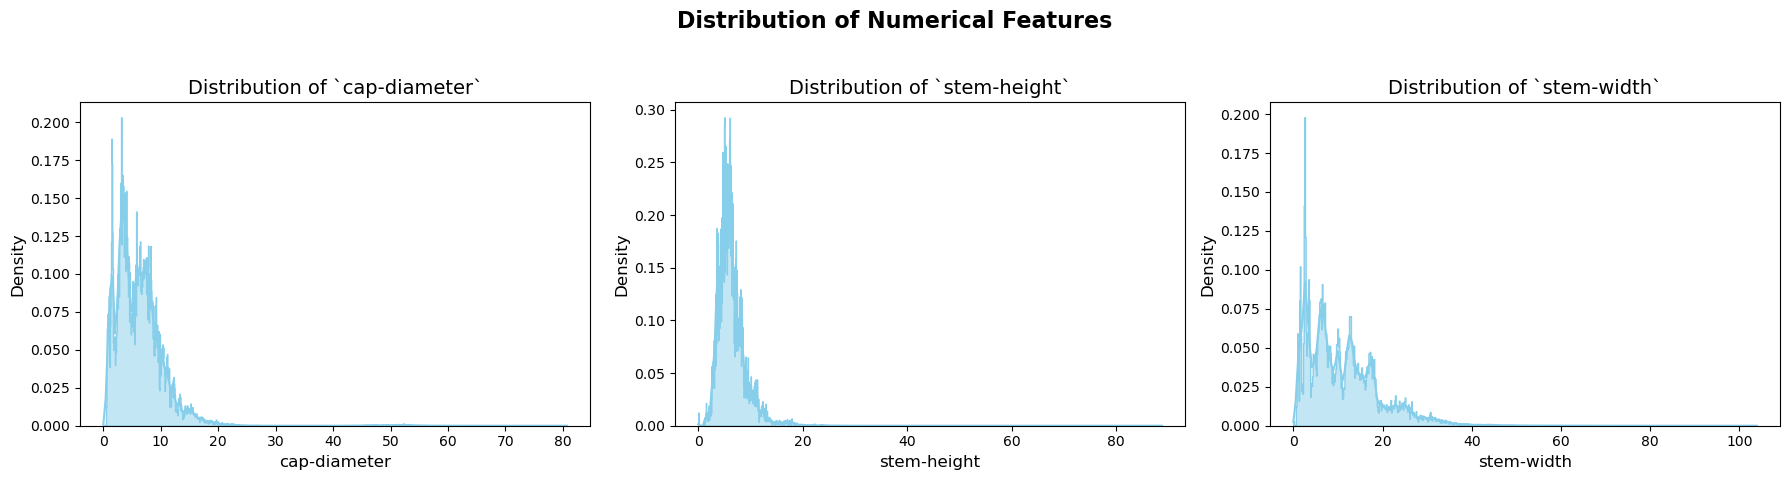

In [11]:
#(3) Draw histogram
draw_hist(df=train_raw.loc[:, num_cols])

##### 02.3.4. **CHECK `CATEGORICAL` VALUES**

In [12]:
cat_cols = train_raw.select_dtypes(include=['object']).columns
for col in cat_cols.drop(labels='class') :
    print(f'>> Check Category Value : "{col}" columns')
    # print(compare_cat_freq(train=train_raw, test=test_raw, pick_col=col, markdown_yn='y'))
    print(summary_cat_cols(df=train_raw, pick_col=col, markdown_yn='y'))
    print(' ')

>> Check Category Value : "cap-shape" columns
┌────┬───────────┬───────────┬─────────┬────────┐
│    │ COL_NM    │ VALUE     │     CNT │   RATE │
├────┼───────────┼───────────┼─────────┼────────┤
│  0 │ cap-shape │ x         │ 1462958 │  46.04 │
├────┼───────────┼───────────┼─────────┼────────┤
│  1 │ cap-shape │ f         │  689642 │  21.70 │
├────┼───────────┼───────────┼─────────┼────────┤
│  2 │ cap-shape │ s         │  372310 │  11.72 │
├────┼───────────┼───────────┼─────────┼────────┤
│  3 │ cap-shape │ b         │  324340 │  10.21 │
├────┼───────────┼───────────┼─────────┼────────┤
│  4 │ cap-shape │ o         │  112151 │   3.53 │
├────┼───────────┼───────────┼─────────┼────────┤
│  5 │ cap-shape │ p         │  109565 │   3.45 │
├────┼───────────┼───────────┼─────────┼────────┤
│  6 │ cap-shape │ c         │  106335 │   3.35 │
├────┼───────────┼───────────┼─────────┼────────┤
│  7 │ cap-shape │ d         │      65 │   0.00 │
├────┼───────────┼───────────┼─────────┼────────┤
│  8

<b></b>

## 03. **CLEANSE DATASETS**

##### 03.1. **COPY DATASETS**

In [13]:
train = train_raw.copy()
test = test_raw.copy()

#### 03.2. **DROP COLUMNS**

- `id`  $ \rightarrow{} $ 삭제

- `stem-root`, `veil-type`, `veil-color`, `spore-print-color` : 결측값 비율 $ 80 \% $ 이상인 열 $ \rightarrow{} $ 대기

In [14]:
train = train.drop(labels='id', axis=1)
test = test.drop(labels='id', axis=1)

#### 03.3. **CLEAN CATEGORICAL VALUES**

- `[0-9]{1,} + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `is + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `does + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `has + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `[a-zA-z]{1} + \s + has-ring` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `\b(\w) \1\b` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

-  `[0-9]{1, }` $ \, \rightarrow{} $ `NA` 처리

-  `[a-zA-z]{2, }` (character length가 $ \, 2 $ 이상인 경우) $ \, \rightarrow{} $ `NA` 처리

In [15]:
#(1) handle categorical values of `train`
train = handle_cat_val(df=train, markdown_yn='y')

>> Handle category value : "cap-shape" columns
┌────┬─────────────┬─────────────┐
│    │ AS_IS_VAL   │ TO_BE_VAL   │
├────┼─────────────┼─────────────┤
│  0 │ 7 x         │ x           │
├────┼─────────────┼─────────────┤
│  1 │ 6 x         │ x           │
├────┼─────────────┼─────────────┤
│  2 │ 3 x         │ x           │
├────┼─────────────┼─────────────┤
│  3 │ is s        │ s           │
├────┼─────────────┼─────────────┤
│  4 │ is p        │ p           │
├────┼─────────────┼─────────────┤
│  5 │ 5 f         │ f           │
├────┼─────────────┼─────────────┤
│  6 │ ring-type   │ NaN         │
├────┼─────────────┼─────────────┤
│  7 │ nan         │ NaN         │
├────┼─────────────┼─────────────┤
│  8 │ b f         │ NaN         │
├────┼─────────────┼─────────────┤
│  9 │ 9.13        │ NaN         │
├────┼─────────────┼─────────────┤
│ 10 │ 8.3         │ NaN         │
├────┼─────────────┼─────────────┤
│ 11 │ 8.29        │ NaN         │
├────┼─────────────┼─────────────┤
│ 12 │ 8

In [16]:
#(2) handle categorical values of `test`
test = handle_cat_val(df=test)
test = handle_unseen_cat_val(train=train, test=test) # test에만 존재하는 cat-val → np.nan

>> Handle category value : "cap-shape" columns
┌────┬──────────────┬─────────────┐
│    │ AS_IS_VAL    │ TO_BE_VAL   │
├────┼──────────────┼─────────────┤
│  0 │ is f         │ f           │
├────┼──────────────┼─────────────┤
│  1 │ 5 f          │ f           │
├────┼──────────────┼─────────────┤
│  2 │ ring-type    │ NaN         │
├────┼──────────────┼─────────────┤
│  3 │ p f          │ NaN         │
├────┼──────────────┼─────────────┤
│  4 │ nan          │ NaN         │
├────┼──────────────┼─────────────┤
│  5 │ cap-diameter │ NaN         │
├────┼──────────────┼─────────────┤
│  6 │ 9.49         │ NaN         │
├────┼──────────────┼─────────────┤
│  7 │ 8.3          │ NaN         │
├────┼──────────────┼─────────────┤
│  8 │ 8            │ NaN         │
├────┼──────────────┼─────────────┤
│  9 │ 7.21         │ NaN         │
├────┼──────────────┼─────────────┤
│ 10 │ 6.75         │ NaN         │
├────┼──────────────┼─────────────┤
│ 11 │ 6.52         │ NaN         │
├────┼───────────

In [17]:
#(3) Check categorical values
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols.drop(labels='class') :
    print(f'>> Check category values : "{col}" columns')
    print(compare_cat_cols(train=train, test=test, pick_col=col, markdown_yn='y'))
    print(' ')

>> Check category values : "cap-shape" columns
┌────┬───────────┬─────────────┬──────────────┬────────────┬─────────────┐
│    │ CAT_VAL   │   TRAIN_CNT │   TRAIN_RATE │   TEST_CNT │   TEST_RATE │
├────┼───────────┼─────────────┼──────────────┼────────────┼─────────────┤
│ 23 │ x         │     1462962 │      46.0360 │     957949 │     46.1004 │
├────┼───────────┼─────────────┼──────────────┼────────────┼─────────────┤
│ 15 │ f         │      689643 │      21.7014 │     452363 │     21.7695 │
├────┼───────────┼─────────────┼──────────────┼────────────┼─────────────┤
│ 21 │ s         │      372311 │      11.7157 │     242698 │     11.6796 │
├────┼───────────┼─────────────┼──────────────┼────────────┼─────────────┤
│  7 │ b         │      324340 │      10.2062 │     211879 │     10.1965 │
├────┼───────────┼─────────────┼──────────────┼────────────┼─────────────┤
│  8 │ o         │      112151 │       3.5291 │      71972 │      3.4636 │
├────┼───────────┼─────────────┼──────────────┼──────

#### 02.3. **CHECK DATASETS**

In [18]:
#(1) Diagnose `train`
diagnose_df(df=train)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,class,object,"3,177,868",0,0.0000,2,0.0000
1,cap-diameter,float64,"3,177,868",4,0.0000,"3,914",0.0012
2,cap-shape,object,"3,177,868",88,0.0000,23,0.0000
3,cap-surface,object,"3,177,868","685,208",0.2156,23,0.0000
4,cap-color,object,"3,177,868",82,0.0000,23,0.0000
5,does-bruise-or-bleed,object,"3,177,868",12,0.0000,22,0.0000
6,gill-attachment,object,"3,177,868","533,845",0.1680,23,0.0000
7,gill-spacing,object,"3,177,868","1,283,527",0.4039,19,0.0000
8,gill-color,object,"3,177,868",121,0.0000,23,0.0000
9,stem-height,float64,"3,177,868",0,0.0000,"2,758",0.0009


In [19]:
#(2) Diagnose `test`
diagnose_df(df=test)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,cap-diameter,float64,"2,077,964",7,0.0000,"3,745",0.0018
1,cap-shape,object,"2,077,964",68,0.0000,23,0.0000
2,cap-surface,object,"2,077,964","446,945",0.2151,23,0.0000
3,cap-color,object,"2,077,964",55,0.0000,23,0.0000
4,does-bruise-or-bleed,object,"2,077,964",13,0.0000,19,0.0000
5,gill-attachment,object,"2,077,964","349,867",0.1684,23,0.0000
6,gill-spacing,object,"2,077,964","839,613",0.4041,16,0.0000
7,gill-color,object,"2,077,964",90,0.0000,23,0.0000
8,stem-height,float64,"2,077,964",1,0.0000,"2,664",0.0013
9,stem-width,float64,"2,077,964",0,0.0000,"5,610",0.0027


<b></b>

## 04. **BUILD MODELS BY `AUTO-GLUON`**

#### 04.1. **SET UP**

In [20]:
#(1) Define `req_dttm`
req_dttm = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

#(1) Define `predictor`
predictor = TabularPredictor(
    label='class',
    eval_metric='mcc',
    problem_type='binary',
    path=f'../temp/{compet_nm}_AutogluonModels_{req_dttm}'
)

#### 04.2. **FIT TRAIN DATASET**

In [21]:
predictor.fit(
    train_data=train,
    excluded_model_types=['KNN'],
    presets='best_quality',
    # num_bag_folds=10,
    # auto_stack=True,
    num_cpus='auto',
    num_gpus='auto',
    # seed=seed_num, # fixed seed = 0 
    time_limit=run_time_limit,
    verbosity=2
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Mon Jul 29 21:14:30 PDT 2024; root:xnu-10063.141.2~1/RELEASE_ARM64_T6000
CPU Count:          10
Memory Avail:       44.38 GB / 64.00 GB (69.3%)
Disk Space Avail:   478.28 GB / 926.35 GB (51.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data.

(_ray_fit pid=9919) [1000]	valid_set's binary_logloss: 0.0364967	valid_set's mcc: 0.984377
(_ray_fit pid=9919) [2000]	valid_set's binary_logloss: 0.0360173	valid_set's mcc: 0.984674 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=9917) [2000]	valid_set's binary_logloss: 0.034967	valid_set's mcc: 0.985111 [repeated 3x across cluster]
(_ray_fit pid=9918) [2000]	valid_set's binary_logloss: 0.034625	valid_set's mcc: 0.985403 [repeated 4x across cluster]
(_ray_fit pid=9919) [3000]	valid_set's binary_logloss: 0.0358858	valid_set's mcc: 0.984806
(_ray_fit pid=9915) [3000]	valid_set's binary_logloss: 0.0345674	valid_set's mcc: 0.985323
(_ray_fit pid=9913) [3000]	valid_set's binary_logloss: 0.0352802	valid_set's mcc: 0.984998 [repeated 2x across cluster]
(_ray_fit pid=9919) [4000]	valid_set's binary_logloss:

(_dystack pid=9908) 	0.985	 = Validation score   (mcc)
(_dystack pid=9908) 	1367.94s	 = Training   runtime
(_dystack pid=9908) 	493.33s	 = Validation runtime
(_dystack pid=9908) Fitting model: LightGBM_BAG_L1 ... Training model for up to 3328.48s of the 5722.64s of remaining time.
(_dystack pid=9908) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=2.01%)


(_ray_fit pid=9987) [1000]	valid_set's binary_logloss: 0.0358535	valid_set's mcc: 0.984529
(_ray_fit pid=9988) [1000]	valid_set's binary_logloss: 0.0354541	valid_set's mcc: 0.984901
(_ray_fit pid=9985) [1000]	valid_set's binary_logloss: 0.0355523	valid_set's mcc: 0.984928 [repeated 6x across cluster]
(_ray_fit pid=9987) [2000]	valid_set's binary_logloss: 0.0356678	valid_set's mcc: 0.984711
(_ray_fit pid=9983) [2000]	valid_set's binary_logloss: 0.0361092	valid_set's mcc: 0.984643
(_ray_fit pid=9985) [2000]	valid_set's binary_logloss: 0.0352952	valid_set's mcc: 0.985094 [repeated 6x across cluster]
(_ray_fit pid=9987) [3000]	valid_set's binary_logloss: 0.0357462	valid_set's mcc: 0.984785
(_ray_fit pid=9989) [3000]	valid_set's binary_logloss: 0.0366486	valid_set's mcc: 0.984383
(_ray_fit pid=9986) [3000]	valid_set's binary_logloss: 0.0359796	valid_set's mcc: 0.984551 [repeated 5x across cluster]
(_ray_fit pid=9988) [4000]	valid_set's binary_logloss: 0.0352789	valid_set's mcc: 0.985318
(_r

(_dystack pid=9908) 	0.9847	 = Validation score   (mcc)
(_dystack pid=9908) 	1169.82s	 = Training   runtime
(_dystack pid=9908) 	357.74s	 = Validation runtime
(_dystack pid=9908) Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 2107.06s of the 4501.22s of remaining time.
(_dystack pid=9908) 	0.9844	 = Validation score   (mcc)
(_dystack pid=9908) 	162.3s	 = Training   runtime
(_dystack pid=9908) 	54.72s	 = Validation runtime
(_dystack pid=9908) Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 1888.34s of the 4282.49s of remaining time.
(_dystack pid=9908) 	0.9844	 = Validation score   (mcc)
(_dystack pid=9908) 	166.91s	 = Training   runtime
(_dystack pid=9908) 	60.38s	 = Validation runtime
(_dystack pid=9908) Fitting model: CatBoost_BAG_L1 ... Training model for up to 1659.34s of the 4053.5s of remaining time.
(_dystack pid=9908) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, me

(_ray_fit pid=10157) [1000]	valid_set's binary_logloss: 0.0349624	valid_set's mcc: 0.985223
(_ray_fit pid=10158) [1000]	valid_set's binary_logloss: 0.0351485	valid_set's mcc: 0.985122


(_dystack pid=9908) 	0.985	 = Validation score   (mcc)
(_dystack pid=9908) 	463.94s	 = Training   runtime
(_dystack pid=9908) 	83.77s	 = Validation runtime
(_dystack pid=9908) Fitting model: LightGBM_BAG_L2 ... Training model for up to 1637.5s of the 1637.34s of remaining time.
(_dystack pid=9908) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=2.54%)
(_dystack pid=9908) 	0.9851	 = Validation score   (mcc)
(_dystack pid=9908) 	57.4s	 = Training   runtime
(_dystack pid=9908) 	3.73s	 = Validation runtime
(_dystack pid=9908) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 1575.37s of the 1575.21s of remaining time.
(_dystack pid=9908) 	0.9851	 = Validation score   (mcc)
(_dystack pid=9908) 	285.82s	 = Training   runtime
(_dystack pid=9908) 	55.18s	 = Validation runtime
(_dystack pid=9908) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 1232.18s of the 1232.02s of remaining

#### 04.3. **CHECK SCORE**

In [22]:
predictor.leaderboard(extra_info=False)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.9853,mcc,1741.3943,14737.3208,0.7252,98.1440,3,True,20
1,RandomForestEntr_BAG_L2,0.9853,mcc,1655.0826,14006.7985,74.5702,439.2980,2,True,14
2,ExtraTreesEntr_BAG_L2,0.9853,mcc,1649.1167,13715.6059,68.6043,148.1053,2,True,17
3,RandomForestGini_BAG_L2,0.9852,mcc,1641.6305,13901.0014,61.1181,333.5009,2,True,13
4,ExtraTreesGini_BAG_L2,0.9852,mcc,1640.9461,13694.7901,60.4337,127.2896,2,True,16
5,WeightedEnsemble_L2,0.9852,mcc,1513.2476,5559.2681,0.7139,49.4243,2,True,10
6,NeuralNetFastAI_BAG_L2,0.9852,mcc,1594.4094,13998.1005,13.8970,430.5999,2,True,18
7,LightGBM_BAG_L2,0.9852,mcc,1583.5976,13621.1736,3.0852,53.6730,2,True,12
8,LightGBMXT_BAG_L1,0.9851,mcc,968.8316,2135.1497,968.8316,2135.1497,1,True,1
9,LightGBMXT_BAG_L2,0.9851,mcc,1682.2553,14656.3460,101.7429,1088.8454,2,True,11


<b></b>

## 05. **CHECK MODEL INTERPRETABILITY**

#### 05.1. **CHECK FEATURE-IMPORTANCE**

In [23]:
#(1) Print feature importance
predictor.feature_importance(data=train)

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	732.18s	= Expected runtime (146.44s per shuffle set)
	313.75s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
gill-attachment,0.0161,0.0026,0.0001,5,0.0215,0.0107
cap-surface,0.0148,0.0020,0.0000,5,0.0189,0.0108
stem-surface,0.0127,0.0020,0.0001,5,0.0169,0.0085
gill-spacing,0.0121,0.0034,0.0006,5,0.0191,0.0052
stem-width,0.0113,0.0014,0.0000,5,0.0142,0.0085
stem-color,0.0096,0.0008,0.0000,5,0.0113,0.0078
stem-root,0.0074,0.0016,0.0003,5,0.0108,0.0040
gill-color,0.0059,0.0012,0.0002,5,0.0083,0.0035
ring-type,0.0041,0.0011,0.0006,5,0.0063,0.0018
cap-diameter,0.0035,0.0019,0.0075,5,0.0074,-0.0004


#### 05.2. **CHECK SHAPLY VALUE**

##### 05.2.1. **SET UP**

In [24]:
#(1)
X_train_pp = predictor.transform_features(data=train).astype(dtype=float)
X_test_pp = predictor.transform_features(data=test).astype(dtype=float)

#(2)
negative_tar = 'e'
CON = (train_raw.loc[:, 'class'] == negative_tar)
baseline = X_train_pp.loc[CON, :].sample(n=100, random_state=seed_num)

#(3)
ag_wrapper = AutogluonWrapper(predictor=predictor, feature_names=X_train_pp.columns, target_class=negative_tar)
explainer = shap.KernelExplainer(model=ag_wrapper.predict_proba, data=baseline)
print(f'>> Baseline prediction : {np.mean(ag_wrapper.predict_proba(X=baseline)):.4f}')  # this is the same as explainer.expected_value

>> Baseline prediction : 0.3542


In [26]:
#(3)
# shap_samples = 15
# shap_values = explainer.shap_values(X=X_train_pp, nsamples=shap_samples)

##### 05.2.3. **DRAW FORCE PLOT (ONE-SAMPLE)**

In [ ]:
#(1) Draw force plot by 1 sample
# row_idx = 0  # index of an example datapoint

#(2)
# single_datapoint = X_train_pp.iloc[[row_idx], :]
# single_prediction = ag_wrapper.predict_proba(X=single_datapoint)

#(3)
# shap_values_single = explainer.shap_values(X=single_datapoint, nsamples=shap_samples)
# shap.force_plot(explainer.expected_value, shap_values_single, X_train_pp.iloc[row_idx, :])

##### 05.2.4. **DRAW FORCE PLOT (N-SAMPLES)**

In [ ]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_test_pp)

##### 05.2.5. **DRAW SUMMARY PLOT**

In [ ]:
# shap.summary_plot(shap_values=shap_values, features=X_test_pp)

<b></b>

## 06. **PREDICT**

#### 06.1. **PREDICT TARGET**

In [ ]:
#(1) Make `pred`
pred = pd.DataFrame(data={
   'id'    : test_raw.loc[:, 'id'].values,
   'class' : predictor.predict(data=test).values
})

#(2) Print `pred`
pred

#### 06.2. **WRITE PREDICT**

In [ ]:
#(1) Define `submission_nm`
submission_nm = f'atogl_stacking_{req_dttm}'

#(2) Write `pred`
pred.loc[:, ['id', 'class']].to_csv(path_or_buf=f'../output/{compet_nm}_{submission_nm}.csv', index=False)